<a href="https://colab.research.google.com/github/eddes/buildingphysics/blob/feature%2Fpipenv_and_notebooks/notebooks/chapter_2/code_IAQ_filtration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor Air Quality

In HVAC, maintenance may often be overlooked, leading to a significant impact on air systems. In this
example, we propose to investigate air filter clogging, estimating its effect on filtration efficiency, fan power
consumption and air quality, with measured outdoor air concentrations for PM2.5.

# Indoor Air Quality

In HVAC, maintenance may often be overlooked, leading to a significant impact on air systems. In this
example, we propose to investigate air filter clogging, estimating its effect on filtration efficiency, fan power
consumption and air quality, with measured outdoor air concentrations for PM2.5.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from tools.plot_tools import colors
import pandas as pd
from  fc_pressure_drop, fc_eta,fc_semaine_type_series, fc_semaine_type_df


### Constant definition

In [0]:
    tau=1# vol/h
#     delta=0.15#    1/h
    eta=0.8 # initial efficiency
#     V=2000 #m3
    qv=2000 #m3/h
    dt=1    #h
    m_limit=30 # max mass before maintenance (g)
    nb_filt=0 # number of filters used
    # load the PM2.5 data


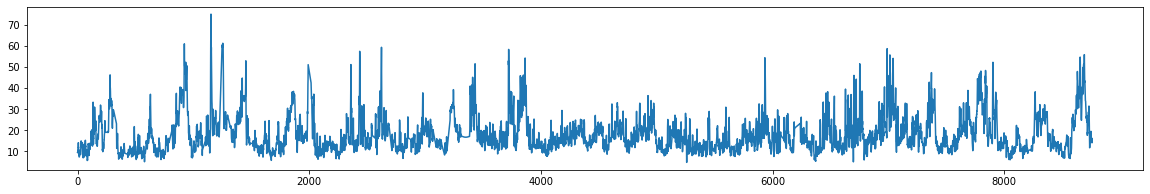

In [0]:
    Cext=np.loadtxt("PM25.txt")
    nb=len(Cext)
    time=np.arange(0,nb,1)
    # Plotting the PM25 distribution over time
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(time,Cext)

In [0]:
# Some basic stats regarding the dataframe
dfC.describe()

NameError: name 'dfC' is not defined

### Main function definition


In [0]:

def simulate_filter_evolution(qv, tau, m_limit):
    nb_filt = 0
    # prepare the vectors for computing
    Csupply=np.zeros(nb)
    C=np.zeros(nb)
    m_filter=np.zeros(nb) # initialy nothing in filter
    eta_filter=np.ones(nb)*eta # initial eta for eta_filter[0] actually (will be updated in the time loop)
    pdc_filter=np.zeros(nb)
    
    Csupply[0]=Cext[0] # aesthetical fill for plotting
    m_filter[0]=1e-4 # against division by !0
    pdc_ref=fc_pressure_drop(0) # reference pressure drop for clean filter
    # time loop
    for i in range(1,nb-1):
        # compute efficiency
        eta_filter[i]=fc_eta(m_filter[i-1])
        # compute the additionnal pressure drop compared to clean filter
        pdc_filter[i]=fc_pressure_drop(m_filter[i-1])-pdc_ref 
        # supply PM2.5 concentration
        Csupply[i]=(1-eta_filter[i])*Cext[i]
        # mass in filter, converted to grams
        m_filter[i]=(Cext[i]-Csupply[i])*qv/1e6 + m_filter[i-1]
        # check if we change the filter
        if m_filter[i]>m_limit:
            m_filter[i]=0
            nb_filt+=1 # count the number of filter change 
        #explicit scheme for C+
        C[i]=C[i-1] + dt*tau*(Csupply[i]-C[i-1])
    # compute the energy use 
    watts_hourly=pdc_filter*qv/3600
    total_kWh=sum(watts_hourly)/1000
    
    # post process and plotting
    a=pd.date_range('1/1/2018', periods=8760, freq='h')
    dfC = pd.DataFrame(index=a)
    
    dfC["PM25"]=Csupply
    dfC["PM25_ext"]=Cext
    dfC["eta"]=eta_filter
    dfC["mass"]=m_filter
    dfC["pdc"]=pdc_filter
    
    # get rid off the last empty index
    dfC=dfC.drop(dfC.index[-1])
    
    typical_week_filt=fc_semaine_type_series(dfC["PM25"],"semaine")
    typical_week_ext=fc_semaine_type_series(dfC["PM25_ext"],"semaine")
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5)

    ax1.set_xlabel("Average PM concentration per week [h]]")
    ax1.grid()
    ax1.set_ylabel(r"$PM_{2.5}$[µg/m$^3$]")
    ax1.plot(typical_week_ext, color=colors[-1], linestyle="-", alpha=0.9, marker='', label='outdoor')
    ax1.plot(typical_week_filt, color=colors[0], linestyle="-", alpha=0.9, marker='', label='indoor')
    ax1.legend()

    ax2.set_xlabel("Filter efficiency")
    ax2.set_ylabel("Efficiency [-]")
    ax2.grid()
    ax2.plot(dfC["eta"],color=colors[2], linestyle="--", alpha=1, marker='')
    ax2.plot()

    ax3.set_xlabel("Filter mass")
    ax3.set_ylabel("Mass in filter [g]")
    ax3.grid()
    ax3.plot(dfC["mass"],color=colors[3], linestyle="--", alpha=1, marker='')
    ax3.plot()

    ax4.grid()
    ax4.set_xlabel("Filter PDC")
    ax4.set_ylabel(r"Additional pressure drop of filter [$\Delta$ Pa]")
    ax4.plot(dfC["pdc"], color=colors[4], linestyle="--", alpha=1, marker='')
    ax4.plot()
    
    ax5.set_xlabel("PM25 over the year")
    ax5.grid()
    ax5.set_ylabel(r"$PM_{2.5}$[µg/m$^3$]")
    ax5.plot(dfC["PM25"], color=colors[-1], linestyle="--", alpha=0.5, marker='')
    ax5.plot()


In [0]:
plt.rcParams["figure.figsize"] = (20,30)

interact_manual(simulate_filter_evolution, qv = widgets.FloatSlider(value=2000,    min=1,
                                               max=10000.0,
                                               step=0.1),
                tau = widgets.FloatSlider(value=0.1,    min=0.01,
                                               max=1,
                                               step=0.1),
                m_limit = widgets.FloatSlider(value=30,    min=1,
                                               max=300.0,
                                               step=0.1)
               
               )

interactive(children=(FloatSlider(value=2000.0, description='qv', max=10000.0, min=1.0), FloatSlider(value=0.1…

<function __main__.simulate_filter_evolution(qv, tau, m_limit)>